# Tugas Video Processing - Implementasi Real-Time Remote Photoplethysmography (rPPG)

<b>Nama     :</b> Deva Ahmad \
<b>NIM      :</b> 122140015

## Deskripsi Tugas
Tugas ini bertujuan untuk memberikan pengalaman praktis kepada mahasiswa dalam mengimplementasikan teknologi Remote Photoplethysmography (rPPG) yang telah dibahas di kelas. Mahasiswa diminta untuk membangun sebuah sistem perangkat lunak yang mampu mendeteksi detak jantung seseorang secara real-time menggunakan kamera (webcam) tanpa kontak fisik.

## Struktur File 
rppg_project/\
├── src/\
│   ├── rppg.py\
│   └── utils.py\
├── tugas_rppg.ipynb\
└── assets/

## Implementasi

### Langkah 1 = Deklarasikan library dan file
Karena file tersimpan dalam folder src, untuk mengintegrasikan file laporan ini dengan file di dalam folder <i>src</i> tulis:

In [2]:
import sys
sys.path.append("src")   # supaya Python tahu folder src bisa di-import





Kemudian instal semua library yang dibutuhkan pada terminal yaitu library:
1. OpenCV = Untuk berbagai tugas pemrosesan gambar dan video, termasuk membaca, menulis, dan memproses gambar dan video.
2. NumPy = Untuk menyediakan objek array N-dimensi (ndarray) untuk melakukan operasi matematika dan logis yang efisien pada array besar.
3. DLIB = Untuk menyediakan algoritma pembelajaran mesin dan pengenalan wajah yang sangat baik.
4. Matplotlib = Untuk membuat berbagai jenis plot (grafik) untuk memvisualisasikan data.
5. SciPy = Untuk menangani pemrosesan sinyal, khususnya untuk detrending, bandpass filtering, dan transformasi Fourier.
6. Collections.deque = Untuk mengelola sliding window sinyal secara efisien pada sistem real-time.
7. MediaPipe = Untuk mengelola data sensorik (gambar, video, audio, teks) secara real-time.

Lakukan Instalasi dengan perintah: \
<i>pip install numpy matplotlib opencv-python dlib scipy mediapipe</i>

### Langkah 2 = Tentukan Pemrosesan pada setiap file

#### Pada modul utils.py berfungsi untuk bangun modul pemrosesan sinyal, tugas yang akan dilakukan adalah:
1. Detrending sinyal dengan moving average (sliding window)
2. Bandpass filter 0.67–4.0 Hz
3. FFT untuk cari frekuensi dominan → BPM

### Pada modul rPPG berfungsi membangun pipeline, tugas yang akan dilakukan adalah:
1. Buka webcam (OpenCV)
2. Deteksi wajah (MediaPipe)
3. Ambil ROI dahi (improvement, lebih stabil)
4. Hitung rata-rata kanal Hijau → masuk ke sliding window
5. Panggil fungsi di utils.py → dapat BPM
6. Tampilkan BPM di frame (real-time), window bergeser terus

### Langkah 3 = Pengembangan pada modul Utilization (Utils.py)
File Utilization berfungsi sebagai penyedia fungsi umum pemrosesan sinyal yang dipakai oleh pipeline rPPG seperti
1. moving average = dasar detrending
2. detrending = buang tren pelan (perubahan cahaya, dsb.)
3. bandpass filter = ambil hanya frekuensi detak jantung
4. FFT → BPM = hitung BPM dari sinyal yang sudah dibersihkan
Selain itu berfungsi juga untuk memisahkan logika pemrosesan sinyal dari logika kamera/UI, supaya kode di rppg.py lebih bersih serta fungsi di utils.py mudah dites, diubah, atau diperbaiki. \
Berikut ini adalah penjelasan terkait function2 pada modul ini:

#### 1. Function moving_average(x, window_size)
Function ini berfungsi untuk menghitung rata-rata bergerak (moving average) dari sinyal 1D.
Rata-rata nanti dipakai sebagai “tren” sinyal yang akan dikurangin pada tahap detrending.
Yang dilakukan di dalam fungsi ini adalah:
1. Konversi input ke np.array tipe float32, Supaya konsisten dan aman untuk operasi numerik.
2. Jika window_size lebih besar dari panjang sinyal, dia dikecilkan supaya tidak lebih besar dari len(x).
3. Selanjutnya membuat kernel untuk menghitung rata-rata.
4. Setelah itu menghitung konvolusi, ini menghasilkan sinyal baru di mana setiap titik adalah rata-rata dari tetangga-tetangganya dalam jendela sepanjang window_size. 
Moving_average menghasilkan sinyal yang halus (low frequency), yang menggambarkan tren pelan dari sinyal.


In [ ]:
def moving_average(x, window_size: int):
    """
    Menghitung rata-rata bergerak (sliding window) dari sinyal 1D.
    Digunakan untuk detrending (menghilangkan tren pelan).
    """
    x = np.asarray(x, dtype=np.float32)

    if window_size < 1:
        raise ValueError("window_size harus >= 1")

    # Jika sinyal terlalu pendek, kecilkan window
    if x.size < window_size:
        window_size = x.size

    kernel = np.ones(window_size, dtype=np.float32) / float(window_size)
    # 'same' -> output panjangnya sama dengan input
    return np.convolve(x, kernel, mode="same")

#### 2. Function detrend_signal(x, window_size=75)
Function ini berfungsi untuk menghilangkan tren pelan (baseline drift) dari sinyal rPPG, misalnya akibat perubahan intensitas cahaya perlahan, sedikit pergerakan kepala, serta perbedaan eksposur kamera. Ini merupakan langkah pembersihan pertama sebelum bandpass filter.
Yang dilakukan di dalam fungsi ini adalah:
1. Memastikan sinyal menjadi array 1D.
2. Menghitung tren dengan function moving_average sebelumnya.
3. Mengurangi tren dari sinyal asli
Hasilnya adalah sinyal yang berosilasi di sekitar nol (lebih “flat” baselinenya), lebih fokus ke perubahan cepat (yang berkaitan dengan detak jantung), dan siap untuk difilter dan di FFT. Sinyal rPPG dari rata-rata kanal hijau biasanya punya drift lambat (naik turun pelan).
Kalau drift ini tidak dibuang, puncak di spektrum frekuensi bisa kotor/bias.

In [ ]:
def detrend_signal(x, window_size: int = 75):
    """
    Menghilangkan tren pelan dari sinyal dengan cara mengurangi
    moving average (sliding window).
    """
    x = np.asarray(x, dtype=np.float32).reshape(-1)
    trend = moving_average(x, window_size=window_size)
    return x - trend

#### 3. Function bandpass_filter(x, fs, low=0.67, high=4.0, order=4)
Function ini berfungsi untuk menerapkan Butterworth band-pass filter ke sinyal, mengizinkan hanya frekuensi antara 0.67 Hz – 4.0 Hz dan membuang frekuensi terlalu rendah dan terlalu tinggi. Rentang ini diambil karena ini adalah rentang kira-kira yaitu: \
a. 0.67 Hz ≈ 40 BPM
b. 4.0 Hz ≈ 240 BPM
Yang dilakukan di dalam fungsi ini adalah:
1. Mengonversi sinyal.
2. Menghitung frekuensi Nyquist.
3. Mengecek bilai high_n > 1, maka dipotong menjadi 0.9999 supaya tidak error.
4. Mendesain filter Butterworth.
5. Menerapkan filter dua arah pakai <i>filtfilt</i>, <i>filtfilt</i> memfilter maju dan mundur dari fase nol (tidak geser fase), hasilnya lebih bersih.
Setelah itu, hasilnya adalah sinyal yang sudah dibersihkan dari noise frekuensi rendah (drift, gerakan pelan, perubahan cahaya), dibersihkan dari noise frekuensi tinggi (noise sensor, flicker tertentu), dan hanya menyimpan komponen yang relevan untuk detak jantung.

In [ ]:
def bandpass_filter(x, fs: float,
                    low: float = 0.67, high: float = 4.0,
                    order: int = 4):
    """
    Menerapkan Butterworth band-pass filter ke sinyal.

    Parameters:
    - x   : sinyal 1D
    - fs  : sampling rate (Hz)
    - low : frekuensi cut-off bawah (Hz)
    - high: frekuensi cut-off atas (Hz)
    """
    x = np.asarray(x, dtype=np.float32).reshape(-1)

    nyq = 0.5 * fs
    low_n = low / nyq
    high_n = high / nyq

    if high_n >= 1.0:
        high_n = 0.999  # jaga-jaga biar tidak error

    b, a = butter(order, [low_n, high_n], btype="bandpass")
    y = filtfilt(b, a, x)
    return y

#### 4. Function get_bpm_from_fft(x, fs, min_bpm=40, max_bpm=240)
Function ini berfungsi untuk mengubah sinyal rPPG yang sudah difilter menjadi nilai BPM dengan FFT untuk pindah ke domain frekuensi. Kemudian mencari frekuensi dominan di rentang detak jantung wajar dan mengonversi frekuensi menjadi BPM. Hasil dari function ini adalah:
a. bpm_peak = nilai BPM dominan (angka float, NaN kalau gagal).
b. bpm_roi = array sumbu x (BPM) untuk spektrum yang sudah di-crop.
c. spec_roi = magnitude spektrum pada frekuensi tersebut.
Yang dilakukan di fungsi ini adalah:
1. Memastikan sinyal 1D.
2. Menghitung FFT hanya frekuensi positif. 
3. Mengonversi frekuensi dari Hz ke BPM.
4. Membatasi hanya ke range detak jantung wajar.
5. Mencari puncak terbesar.


In [ ]:
def get_bpm_from_fft(x,
                     fs: float,
                     min_bpm: float = 40.0,
                     max_bpm: float = 240.0):
    """
    Menghitung BPM dari sinyal rPPG dengan FFT.

    Returns:
    - bpm_peak : nilai BPM dominan (float) atau NaN jika gagal
    - bpm_axis : array BPM untuk sumbu x spektrum
    - spec_roi : magnitude spektrum (sesuai bpm_axis)
    """
    x = np.asarray(x, dtype=np.float32).reshape(-1)
    n = x.size

    if n < 2:
        return np.nan, None, None

    # FFT hanya bagian frekuensi positif
    yf = rfft(x)
    xf = rfftfreq(n, d=1.0 / fs)  # frekuensi dalam Hz

    bpm = xf * 60.0  # konversi Hz -> BPM
    spectrum = np.abs(yf)

    # Batasi ke rentang detak jantung manusia yang wajar
    mask = (bpm >= min_bpm) & (bpm <= max_bpm)
    if not np.any(mask):
        return np.nan, bpm, spectrum

    bpm_roi = bpm[mask]
    spec_roi = spectrum[mask]

    idx_peak = int(np.argmax(spec_roi))
    bpm_peak = float(bpm_roi[idx_peak])

    return bpm_peak, bpm_roi, spec_roi

Fungsi dalam kontek rPPG adalah sinyal setelah filter masih di domain waktu → kita belum tahu frekuensinya berapa. Dengan FFT, kita dapat spektrum frekuensi sehingga terlihat puncak dominan. Puncak tersebut diinterpretasikan sebagai detak jantung (asumsi sinyal sudah cukup bersih).

### Langkah 4: Pengembangan pada modul rPPG (rPPG.py)
File rPPG berfungsi sebagai "mesin utama" pada sistem rPPG. Kalau utils.py berfungsi sebagai otak pemrosesan sinyal (detrend, filter, FFT menjadi BPM). rPPG adalah otak aplikasi dimana:
1. Baca webcam
2. Deteksi wajah
3. Ambil ROI dahi
4. Ekstrak sinyal hijau ke buffer
5. Panggil fungsi di utils.py untuk hitung BPM
6. Tampilkan BPM secara real-time di jendela video
Pada file ini terdapat kelas yaitu Class RPPGPipeline yang membungkus seluruh alur rPPG. Kelas ini berfungsi untuk:
A. Menginisialisasi parameter (durasi window, estimasi fps, smoothing, dll.).
D. Mendeteksi wajah pakai MediaPipe untuk bounding box wajah.
C. Menentukan ROI dahi dari bounding box.
D. Menghitung rata-rata kanal hijau ROI untuk masuk ke sliding window (deque).
E. Ketika data di buffer cukup:
    a. Menghitung fs (sampling rate) dari timestamp
    b. Melakukan detrend sinyal
    c. Melakukan bandpass filter
    d. Mengubah FFT menjadi BPM
    e. smoothing BPM
F. Tampilkan BPM di tampilan video

In [ ]:
class RPPGPipeline:
    """
    Pipeline utama rPPG:
    - Buka webcam
    - Deteksi wajah (MediaPipe)
    - Ambil ROI dahi
    - Ekstraksi sinyal hijau (spatial averaging)
    - Sliding window + filtering + FFT -> BPM
    """

Berikut ini adalah function/method yang ada pada kelas ini:
#### 1. Method __init__()
Method ini adalah konstruktor class, berfungsi untuk mengatur parameter dan menyiapkan objek yang dibutuhkan. Parameter penting pada method ini yaitu:
1. camera_index: index webcam (default 0)
2. window_seconds: panjang sliding window, misal 10 detik
3. fps_guess: tebakan awal fps untuk menentukan ukuran buffer deque
4. min_seconds_for_bpm: minimal durasi data di buffer sebelum kita berani menghitung BPM (misal 5 detik)
5. show_debug: apakah menampilkan info tambahan di frame (samples, durasi, dll.)

Yang dilakukan pada method ini yaitu:
1. signal_buffer = menyimpan nilai rata-rata kanal hijau per frame.
2. time_buffer = menyimpan timestamp masing-masing nilai.

In [ ]:
def __init__(
    self,
    camera_index: int = 0,
    window_seconds: float = 10.0,
    fps_guess: float = 30.0,
    min_seconds_for_bpm: float = 5.0,
    show_debug: bool = True,
):
    # Parameter input
    self.camera_index = camera_index
    self.window_seconds = window_seconds
    self.fps_guess = fps_guess
    self.min_seconds_for_bpm = min_seconds_for_bpm
    self.show_debug = show_debug

    # Buffer sliding window untuk sinyal dan waktu
    max_len = int(window_seconds * fps_guess)
    self.signal_buffer = deque(maxlen=max_len)  # nilai mean hijau
    self.time_buffer = deque(maxlen=max_len)    # timestamp

Menghitung Estimasi BPM dimana:
1. self.current_bpm = BPM mentah terakhir
2. self.smooth_bpm = BPM yang sudah di-smooth (exponential smoothing)
3. self.alpha_bpm = 0.8 = faktor penghalus (semakin besar = lebih halus, tapi respons lambat)

In [ ]:
# Estimasi BPM (raw dan smoothed)
self.current_bpm = np.nan
self.smooth_bpm = np.nan
self.alpha_bpm = 0.8  # smoothing faktor (0-1), makin besar -> makin halus

#### 2. Method _detect_face_bbox(self, frame_rgb)
Method ini berfungsi untuk mendeteksi wajah dalam frame RGB dan mengembalikan bounding box dalam satuan pixel. Alur yang terjadi pada method ini adalah:
1. Memanggil MediaPipe

In [ ]:
def _detect_face_bbox(self, frame_rgb):
    """
    Mendeteksi wajah dan mengembalikan bounding box (x, y, w, h) dalam pixel.
    Jika tidak ada wajah -> None.
    """
    results = self.face_detector.process(frame_rgb)

2. Kalau tidak ada wajah maka mengembalikan None.
3. Kalau ada, ambil deteksi dengan score tertinggi.

In [ ]:
# Ambil deteksi dengan skor tertinggi
det = max(results.detections, key=lambda d: d.score[0])
bbox = det.location_data.relative_bounding_box

4. MediaPipa kasih bounding box dalam bentuk koordinat relatif [0,1], maka dikonversi ke pixel.

In [ ]:
x = int(bbox.xmin * w)
y = int(bbox.ymin * h)
bw = int(bbox.width * w)
bh = int(bbox.height * h)


5. Di-clamp supaya tidak keluar area frame. Mengembalikan (x, y) untuk titik kiri-atas wajah serta (bw, bh) untuk lebar dan tinggi wajah. Method ini yang menghubungkan domain “gambar” dengan ROI yang nanti kita pakai sebagai sumber sinyal.

#### 3. Method _get_forehead_roi(self, frame_bgr, face_bbox)
Method ini berfungsi untuk mengambil Region of Interest (ROI) di area dahi dari bounding box wajah. Alasan mengambil di dahi karena sebagai improvement sebab kulit relatif lebih rata, minim gerakan mulut/rahang, dan sering dipakai di paper rPPG sebagai ROI yang stabil. Berikut adalah cara kerja method ini:

In [ ]:
def _get_forehead_roi(self, frame_bgr, face_bbox):
    """
    Mengambil ROI di area dahi dari bounding box wajah.
    Ini improvement agar sinyal lebih stabil (kulit dahi biasanya lebih uniform).
    """
    x, y, bw, bh = face_bbox

    # Ambil bagian atas wajah (sekitar dahi)
    top_y = y + int(0.15 * bh)
    bottom_y = y + int(0.35 * bh)

    left_x = x + int(0.2 * bw)
    right_x = x + int(0.8 * bw)

    top_y = max(y, top_y)
    bottom_y = min(y + bh, bottom_y)
    left_x = max(x, left_x)
    right_x = min(x + bw, right_x)

1. Ambil bagian atas wajah antara 15%–35% tinggi bounding box = kira-kira dahi.
2. Ambil bagian tengah horizontal antara 20%–80% lebar bounding box = hindari area pinggir.
Kemudian ROI dipotong dan mengembalikan nilai roi untuk citra BGR area dahi dan (left_x, top_y, right_x, bottom_y) untuk koordinat untuk digambar kotak hijau di frame (feedback visual ke user).

#### 4. Method _update_signal_buffer(self, value, timestamp)
Method ini berfungsi untuk menambahkan satu sample sinyal ke dalam sliding window.

In [ ]:
def _update_signal_buffer(self, value: float, timestamp: float):
    """Menambahkan satu sample sinyal dan timestamp ke buffer sliding window."""
    self.signal_buffer.append(float(value))
    self.time_buffer.append(float(timestamp))


1. Value = rata-rata kanal hijau ROI untuk satu frame
2. timestamp = waktu pengambilan frame (dari time.time())\

Karena pakai deque dengan maxlen, ketika buffer penuh, data lama otomatis terbuang sehingga inilah yang membuat sliding window.

#### 5. Method _estimate_fs_from_time_buffer(self)
Method ini berfungsi untuk mengestimasi sampling rate (fs) berdasarkan jarak waktu antara sample-sample di buffer, bukan hanya dari fps kamera.

In [ ]:
def _estimate_fs_from_time_buffer(self):
    """
    Mengestimasi frekuensi sampling (fs) dari time_buffer
    menggunakan durasi real (bukan sekadar fps kamera).
    """
    if len(self.time_buffer) < 2:
        return None

    duration = self.time_buffer[-1] - self.time_buffer[0]
    if duration <= 0:
        return None

    fs = len(self.time_buffer) / duration
    return fs

1. Kalau jumlah time_buffer < 2 → tidak bisa hitung maka menghasilkan None
2. Menghitung durasi\
duration = self.time_buffer[-1] - self.time_buffer[0]
fs = len(self.time_buffer) / duration\
fs = jumlah sample/durasi

#### 6. Method _estimate_bpm_from_buffer(self)
Method ini adalah inti pipeline sinyal di class ini. Method ini berfungsi untuk mengambil data di buffer kemudian memproses sinyal lengkap sehingga menghasilkan BPM serta update smoothing.

In [ ]:
def _estimate_bpm_from_buffer(self):
        """
        Pipeline pemrosesan sinyal:
        - cek panjang waktu minimum
        - detrending
        - bandpass filter
        - FFT -> BPM
        - smoothing BPM
        """
        if len(self.signal_buffer) < 2:
            return None

        # Cek durasi minimal
        duration = self.time_buffer[-1] - self.time_buffer[0]
        if duration < self.min_seconds_for_bpm:
            return None

        sig = np.array(self.signal_buffer, dtype=np.float32)
        fs = self._estimate_fs_from_time_buffer()
        if fs is None or fs < 5.0:
            # Sampling terlalu rendah -> sinyal tidak valid
            return None

        # 1) Detrend dengan sliding window ~1 detik
        window_size = int(fs * 1.0)  # 1 detik
        if window_size < 3:
            window_size = 3
        sig_detrended = detrend_signal(sig, window_size=window_size)

        # 2) Bandpass filter 0.67 - 4.0 Hz
        sig_filtered = bandpass_filter(sig_detrended, fs=fs,
                                       low=0.67, high=4.0, order=4)

        # 3) FFT -> BPM
        bpm_raw, bpm_axis, spec_roi = get_bpm_from_fft(sig_filtered, fs=fs)

        if np.isnan(bpm_raw):
            return None

        self.current_bpm = bpm_raw

        # 4) Smoothing BPM (improvement untuk stabilitas nilai yang ditampilkan)
        if np.isnan(self.smooth_bpm):
            self.smooth_bpm = bpm_raw
        else:
            self.smooth_bpm = (
                self.alpha_bpm * self.smooth_bpm
                + (1.0 - self.alpha_bpm) * bpm_raw
            )

        return bpm_raw

Langkah-langkah yang dilakukan pada file ini yaitu:
1. Mengecek jumlah sample.
2. Menghitung durasi. Jika belum cukup panjang (misal < 5 detik) maka jangan hitung BPM dulu.
3. Mengonveri ke array, kalau fs sangat kecil maka tidak valid.
4. Melakukan Detrending (pakai detrend_signal dari utils.py).
5. Melakukan Bandpass filter (pakai bandpass_filter dari utils.py).
6. FFT diubah menjadi BPM (pakai get_bpm_from_fft dari utils.py).
7. Simpan BPM mentah.
8. Smoothing BPM (improvement untuk stabilitas tampilan). Alpha_bpm mendekati 1 maka perubahan nilai BPM di layar jadi halus, tidak “loncat loncat”. Ini menghasilkan BPM mentah (bpm_raw) atau None kalau belum bisa dihitung.

#### 7. Method run(self)
Method ini adalah main loop real-time. Jika dipanggil sekali, lalu method ini akan:
1. Membuka webcam
2. Melakukan loop baca frame
3. Mendeteksi wajah
4. Mengambil ROI dahi + ekstrak sinyal
5. Melakukan estimasi BPM
6. Menggambar BPM ke frame
7. Menampilkan video

Detail alurnya adalah:
1. Buka Kamera


In [ ]:
def run(self):
        """
        Menjalankan pipeline rPPG secara real-time.
        Tekan 'q' di jendela video untuk keluar.
        """
        cap = cv2.VideoCapture(self.camera_index)
        if not cap.isOpened():
            raise RuntimeError("Tidak dapat membuka kamera (webcam).")

2. Coba baca FPS kamera:

In [ ]:
# Coba baca FPS dari kamera (kalau ada)
fps_cam = cap.get(cv2.CAP_PROP_FPS)
if fps_cam is not None and fps_cam > 1:
    self.fps_guess = fps_cam

    max_len = int(self.window_seconds * self.fps_guess)
    self.signal_buffer = deque(self.signal_buffer, maxlen=max_len)
    self.time_buffer = deque(self.time_buffer, maxlen=max_len)

3. Masuk ke loop

In [ ]:
while True:
    ret, frame = cap.read()
    if not ret:
        print("Gagal membaca frame dari kamera.")
        break

4. Mirror frame (flip) supaya kayak ngaca

In [ ]:
# Mirror agar lebih natural (seperti ngaca)
frame = cv2.flip(frame, 1)

5. Convert ke RGB untuk MediaPipe

In [ ]:
# MediaPipe butuh RGB
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

6. Deteksi wajah

In [ ]:
 # Deteksi wajah
face_bbox = self._detect_face_bbox(frame_rgb)

timestamp = time.time()

7. Kalau wajah terdeteksi maka

A. Ambil ROI dahi

In [ ]:
if face_bbox is not None:
    # Ambil ROI dahi
    roi, (x1, y1, x2, y2) = self._get_forehead_roi(frame, face_bbox)

B. Kalau ROI tidak kosong maka ambil kanal hijau, kemudian masukkan ke buffer dan membuat gambar kotak ROI di frame.

In [ ]:
if roi.size != 0:
    # Kanal Hijau = index 1 (BGR -> G)
    green_channel = roi[:, :, 1]
    mean_green = float(np.mean(green_channel))

    self._update_signal_buffer(mean_green, timestamp)

    # Gambar kotak ROI sebagai feedback visual
    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

8. Hitung BPM dari buffer

In [ ]:
# Estimasi BPM dari buffer
bpm_est = self._estimate_bpm_from_buffer()

9. Siapkan teks BPM, lalu digambar ke frame.

In [ ]:
# Teks BPM
if self.smooth_bpm is not None and not np.isnan(self.smooth_bpm):
    text_bpm = f"BPM: {self.smooth_bpm:.1f}"
else:
    text_bpm = "BPM: --"

cv2.putText(
    frame,
    text_bpm,
    (20, 40),
    cv2.FONT_HERSHEY_SIMPLEX,
    1.0,
    (0, 255, 0),
    2,
    cv2.LINE_AA,
)

10. Kalau show_debug aktif, tampilkan info jumlah sample dan durasi window.

In [ ]:
if self.show_debug:
    # Tambahan: tampilkan jumlah sample & durasi buffer
    if len(self.time_buffer) >= 2:
        duration = self.time_buffer[-1] - self.time_buffer[0]
        debug_text = f"Samples: {len(self.signal_buffer)} | Win: {duration:.1f}s"
        cv2.putText(
            frame,
            debug_text,
            (20, 70),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 255, 255),
            1,
            cv2.LINE_AA,
        )

11. Tampilkan frame

In [ ]:
cv2.imshow("rPPG – Real-time Heart Rate (press 'q' to quit)", frame)

12. Keluar kalau user tekan "q"

In [3]:
# key = cv2.waitKey(1) & 0xFF
# if key == ord("q"):
#     break

13. Terakhir, rilis resource

In [ ]:
cap.release()
cv2.destroyAllWindows()


### Langkah 5: Melakukan run terhadap program
Setelah itu, langkah terakhir adalah melakukan running program dengan mengimport class RPPGPipeline dari file rppg.py. Berikut adalah kode eksekusinya:

In [8]:
from rppg import RPPGPipeline

pipeline = RPPGPipeline(
    camera_index=0,
    window_seconds=10.0,
    fps_guess=30.0,
    min_seconds_for_bpm=5.0,
    show_debug=True,
)

pipeline.run()

Tekan 'q' untuk keluar dari program.


## Analisis
Setelah mengaktifkan deteksi, didapatkan hasil gambar screenshot dari video dibawah ini:

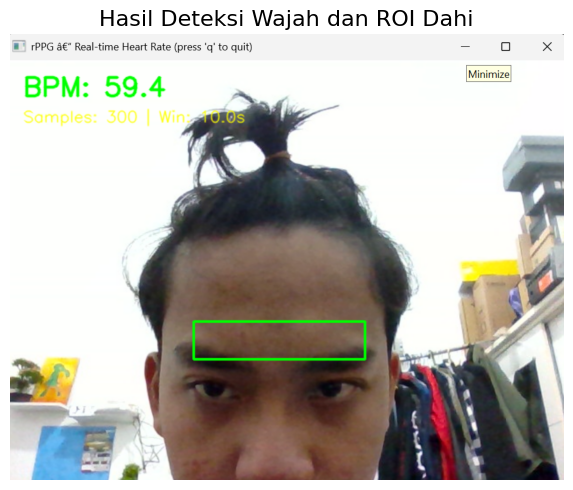

Gambar berhasil dimuat dan ditampilkan.
Dimensi gambar: (762, 946, 3)


In [9]:
import cv2  
import os
import matplotlib.pyplot as plt

# Path gambar
img_path = os.path.join(os.getcwd(), 'assets', 'hasil.png')

# Baca gambar
img = cv2.imread(img_path)

# Konversi BGR → RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Plot berdampingan
fig, axs = plt.subplots(1, 1, figsize=(15, 5))

axs.imshow(img_rgb)
axs.set_title('Hasil Deteksi Wajah dan ROI Dahi', fontsize=16)
axs.axis('off')

plt.tight_layout()
plt.show()

print("Gambar berhasil dimuat dan ditampilkan.")
print(f"Dimensi gambar: {img_rgb.shape}")

### 1. BPM dan Kestabilan Estimasi
Nilai 59.4 BPM menunjukkan detak jantung yang sedang rendah atau dalam posisi santai. Nilai BPM tidak terjadi perubahan nilai yang sangat fluktuatif menandakan smoothing BPM berjalan baik, bandpass filter bekerja dengan stabil, dan movement artifacts kecil. 

### 2. Bounding Box ROI berada di area dahi
Bounding box ROI berada di area dahi meskipun sedikit turun, berada di area atas alis dan bukan ke mata dan tidak terkena rambut. Tandanya adalah ROI dahi sudah terset dengan benar, pemilihan area dahi efektif untuk mengurangi noise pergerakan mulut dan pipi serta deteksi wajah dari MediaPipe stabil.

### 3. Kondisi lighting kurang ideal
Dari screenshot, terlihat bahwa kondisi lighting kurang ideal karena lampu terlalu terang, sebagian wajah tertutup shadow halus, tetapi intensitas cahaya masih cukup untuk mengekstraksi sinyal channel hijau. Efek backlight mengakibatkan sinyal rPPG lebih lemah, noise lebih tinggi serta BPM bisa under/overestimate. Namun pada screenshot BPM tetap stabil menandakan pipeline (detrending + bandpass + smoothing) mampu mengatasi noise tersebut. 

### 4. Samples: 300 | Win: 10.0s
Parameter ini sangat penting untuk dianalisis, menandakan bahwa dalam 10 detik window sliding, pengguna mendapat sekitar 30 fps. Ini mengindikasikan kalau webcam berjalan stabil pada 30 frame per detik. Semakin banyak sample, semakin baik estimasi FFT. Kemudian ini menunjukkan durasi sliding window sama dengan 10 detik. Hal ini ideal untuk rPPG. Lalu bila waktu window terpenuhi maka estimasi BPM menjadi valid dan tidak mengalami frame drop yang signifikan.


### Referensi
[Link Percakapan ChatGPT](https://chatgpt.com/c/692dad63-7edc-8320-bb34-8f2810fffc1a)